# Convets reentrenadas

Las dos caracteristicas a considerar en Redes Neuronales Reentrenadas son: extracción de característicasd y ajuste fino.

## Extracción de características

Consiste en utilizar las representaciones aprendidas por una red anterior para extraer caracateristicas interesantes de una nueva muestra. Luego, estas nuevas caracteristicas se ejecutan a través de un nuevo clasificador, que se entrena desde cero.

Solo se reutilizan el reentrenamiento de la base convolucional debido que en esta base el aprendizaje es más generico, y por lo tanto, más reutilizables.

Los mapas de caracteristicas de una convets son mapas de presencia de conceptos genericos sobre una imagen, lo que probablemente sea más útil sin importar cuál sea el problema de visión por ordenador que tenemos entre manos.

Las representaciones que se encuentran en las capas densamente conectadas ya no contienen ninguna información acerca de dónde se encuentran los objetos de la imagen de entrada. Para los problemas en las que las ubicaciones de los objetos es importante. las caracteristicas densamente conectadas son, en esencia, inútiles.

El nivel de generalidad de las representaciones extraídas por capas convolucionales especificas dependen de la profundidad de la capa en el modelo. Si nuestro conjunto de datos difiere mucho del conjunto de datos con que se entrenó el modelo original, puede que sea mejor utilizar solo las primeras capas del modelo para extraer las caracteristicas.

### Base convolucional de la red VGG16

Modelo antiguo entrenado del dataset ImageNet

In [1]:
# Creación de instancia de la base convolucional VGG16
from keras.applications import VGG16

con_base = VGG16(
    weights='imagenet', # punto de control de los pesos a partir de cual se inicializa el modelo
    include_top=False, # incluir (o no) el clasificador densamente conectado en la red
    input_shape=(150, 150, 3) # forma de los tensores de la imagen que se introducirá
)

Using TensorFlow backend.


In [2]:
con_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Una vez cargado el modelo base, podemos proceder de dos formas:

- Ejecutar la base convolucional sobre un conjunto de datos, grabando su salida a una matriz Numpy en disco y utilizar luego esos datos como entrada para un clasificador independiente densamente conectado. Esta es una solución rápida y barata a la hora de ejecutarse, por que solo requiere la ejecución de la base convolucional una vez para cada imagen de entrada. La base convolucional es, con creces, la parte más cara de la red. Esta técnica no permite utilizar aumento de datos.

- Ampliar el modelo (con_base) añadiendo capas densas encima y ejecutándolo todo de principio a fin con los datos de entrada. Esto permite utilizar aumento de datos, por que cada imagen de entrada pasa a través de la base convolucional cada vez que el modelo la ve. 

## Extracción de características rápidas sin aumento de datos

Utilizamos ImageDataGenerator para extraer imagenes como matrices Numpy y sus etiquetas.

Para extraer características de esas imágenes, se llama al método _predict_ del modelo _con_base_.

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/tf/deep_learning_keras/data/cats_and_dogs/'
train_dir = os.path.join(base_dir, 'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')
test_dir = os.path.join(base_dir, 'test_dir')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = 'binary'
    )
    i = 0
    for input_batch, labels_batch in generator:
        features_batch = con_base.predict(input_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
        return features, labels
    
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# las características extraídas tienen la forma (sample, 4, 4, 512)
# se necesita incluir en un clasificador densamente conectado
# debemos aplanarla en: (samples, 8192)
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2002 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
# Definir y entrenar el cluster densamente conectado

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim= 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 767us/step - loss: 0.6918 - accuracy: 0.9945 - val_loss: 0.6856 - val_accuracy: 0.9920
Epoch 2/30
2000/2000 [==============================] - 1s 574us/step - loss: 0.6830 - accuracy: 0.9965 - val_loss: 0.6780 - val_accuracy: 0.9930
Epoch 3/30
2000/2000 [==============================] - 1s 592us/step - loss: 0.6765 - accuracy: 0.9965 - val_loss: 0.6706 - val_accuracy: 0.9960
Epoch 4/30
2000/2000 [==============================] - 1s 540us/step - loss: 0.6690 - accuracy: 0.9970 - val_loss: 0.6635 - val_accuracy: 0.9930
Epoch 5/30
2000/2000 [==============================] - 1s 552us/step - loss: 0.6607 - accuracy: 0.9975 - val_loss: 0.6555 - val_accuracy: 0.9940
Epoch 6/30
2000/2000 [==============================] - 1s 564us/step - loss: 0.6534 - accuracy: 0.9975 - val_loss: 0.6476 - val_accuracy: 0.9950
Epoch 7/30
2000/2000 [==============================] - 1s 530us/step - loss

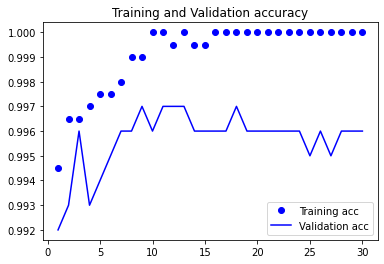

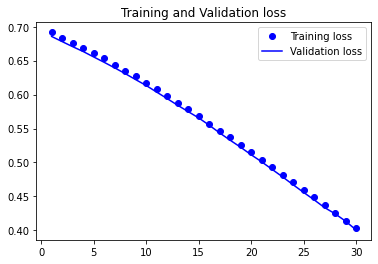

In [5]:
# resultados
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

## Extracción de caracteristicas con aumento de datos

Técnica más cara y lenta pero permite aumentar los datos.

In [6]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(con_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


Antes de entrenar se debe congelar la base convolucional, o sea, evitar que los pesos se actualicen durante el entrenamientol. 

In [7]:
con_base.trainable = False

Solo se entrenaran los pesos de las dos capas densamente conectadas.

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['accuracy']
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2002 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 21s 207ms/step - loss: 0.5784 - accuracy: 0.7008 - val_loss: 0.2930 - val_accuracy: 0.8240
Epoch 2/30
100/100 [==============================] - 19s 191ms/step - loss: 0.4750 - accuracy: 0.7906 - val_loss: 0.4273 - val_accuracy: 0.8560
Epoch 3/30
100/100 [==============================] - 16s 164ms/step - loss: 0.4336 - accuracy: 0.8012 - val_loss: 0.2758 - val_accuracy: 0.8660
Epoch 4/30
100/100 [==============================] - 16s 157ms/step - loss: 0.4039 - accuracy: 0.8169 - val_loss: 0.3776 - val_accuracy: 0.8690
Epoch 5/30
100/100 [==============================] - 16s 158ms/step - loss: 0.3839 - accuracy: 0.8244 - val_loss: 0.1649 - val_accuracy: 0.8810
Epoch 6/30
100/100 [==============================] - 16s 161ms/step - loss: 0.3528 - accuracy: 0.8481 - val_loss: 0.2689 - val_accuracy: 0.8570
Epoch 7/30
100/100 [==========================

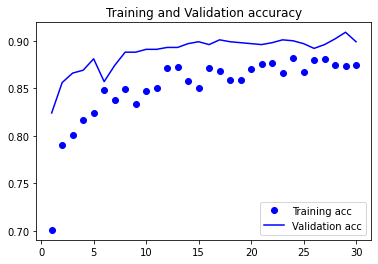

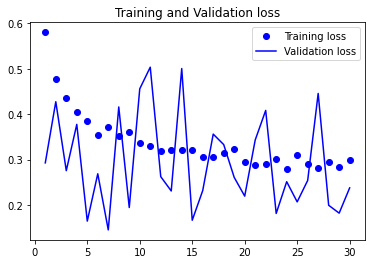

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

## Ajuste Fino

Otra técnica para reutilizar el modelo, complementaria de la extracción de caracaterístcias, es el ajuste fino.

Consiste en descongelar algunas capas superiores de una base de modelo congelada utilizada para la extracción de características y entrenar de manera conjunta la parte recién añadida del modelo (modelo densamente conectado) y estas capas superiores.

Se llaama ajuste fino porque ajusta ligeramente las representaciones más abastractas del modelo (capas superiores) que se esta reutilizando.

Los pasos para realizar ajuste fino son los siguiente:

1. Añadir la red personalizada encima de una red base ya entrenada
2. Congelar la red base
3. Entrenar la parte que hemos añadido
4. Descongelar algunas capas de la red
5. Entrenar de manera conjunta estas capas y la parte que hemos añadido

In [10]:
con_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

¿Por qué no utilizar el ajuste fino en más capas?

- Las primeras capas de la base convolucional codifican características reutilizables más genéricas, mientras que las capas superiores codifican características más especializadas.
- Cuantos más parámetros estamos entrenando, más riesgos de sobre-ajuste hay.

En este caso, es buena estrategia utilizar ajuste fino a solo 2 o 3 capas superiores de la base convolucional.

In [11]:
# Congelar todas las capas hasta una especifica

con_base.traineable = True

set_trainable = False
for layer in con_base.layers:
    set_trainable = True if layer.name == 'block_conv1' else False
    layer.trainable = True if set_trainable else False

In [12]:
# Ajuste fino del modelo

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 17s 165ms/step - loss: 0.2869 - accuracy: 0.8759 - val_loss: 0.0697 - val_accuracy: 0.9070
Epoch 2/100
100/100 [==============================] - 17s 172ms/step - loss: 0.2642 - accuracy: 0.8855 - val_loss: 0.0774 - val_accuracy: 0.8990
Epoch 3/100
100/100 [==============================] - 17s 169ms/step - loss: 0.2733 - accuracy: 0.8824 - val_loss: 0.3852 - val_accuracy: 0.9000
Epoch 4/100
100/100 [==============================] - 16s 156ms/step - loss: 0.2873 - accuracy: 0.8734 - val_loss: 0.1035 - val_accuracy: 0.9040
Epoch 5/100
100/100 [==============================] - 16s 157ms/step - loss: 0.2629 - accuracy: 0.8910 - val_loss: 0.4862 - val_accuracy: 0.9050
Epoch 6/100
100/100 [==============================] - 15s 155ms/step - loss: 0.2820 - accuracy: 0.8855 - val_loss: 0.1058 - val_accuracy: 0.9060
Epoch 7/100
100/100 [==============================] - 15s 154ms/step - loss: 0.2756 - accuracy: 0.8835 - val_loss: 0.2352 -

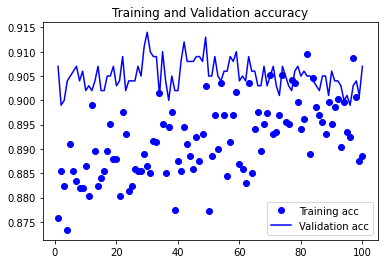

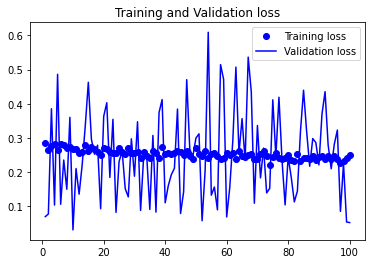

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

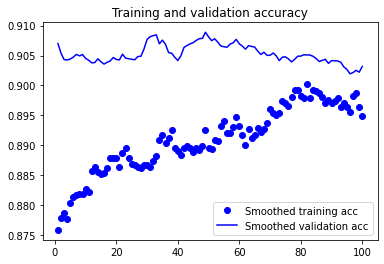

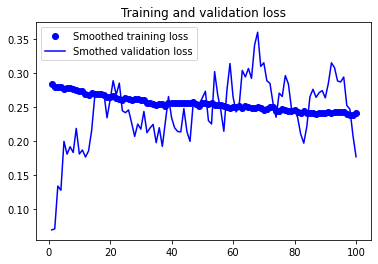

In [16]:
# Estabilizar los gráficos

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1  - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smoth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smoth_curve(val_loss), 'b', label='Smothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Se observa que la curva de perdida se deteriora, sin embargo, lo que importa para la exactiud es la distribución de los valores de pérdida, no su media, por que la exactitud es el resultado de un umbral binario de la probabilidad de clase prodicha por el modelo.

Puede que el modelo siga mejorando incluso si eso no se refleje en la pérdida media.

In [18]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc: ', test_acc)

Found 1000 images belonging to 2 classes.
test acc:  0.8989999890327454
